# Multiple Linear Regression Portfolio Project: TV Advertising vs Advertising Budget

A hands-on analytical project that investigates the **impact of TV advertising on product sales** using **Multiple Linear Regression**. This project includes:

- **Data Visualization** — Explore relationships between variables  
- **Manual OLS Calculation** — Derive Ordinary Least Squares estimates step-by-step  
- **Hypothesis Testing** — Assess overall model significance using statistical tests  
- **Feature Selection** — Use forward and backward selection to identify key predictors  
- **Model Evaluation** — Interpret R², Residual Standard Error (RSE), and percentage error  
- **Interaction Analysis** — Identify synergy effects among advertising media  
- **Linearity Check** — Use residual plots to examine model assumptions  

This project provides a comprehensive understanding of how advertising budgets influence sales and how statistical modeling can guide marketing decisions.

<div class="alert alert-info" style="margin: 20px">
  While more complex models (e.g., KNN, Decision Trees, or ensemble methods) may be considered in other contexts, this project focuses on <strong>Multiple Linear Regression</strong> due to its <strong>interpretability, foundational importance, and relevance in statistical learning</strong>. 
</div>

> **Note:** A **train-test split** is **not conducted** in this project, as the emphasis is on **understanding the full dataset and building interpretive insights**, rather than optimizing for predictive performance.

---

## Background

**Simple Linear Regression** is a valuable approach for predicting a response variable based on a single predictor. However, in real-world scenarios, we often have **multiple predictors**. 

For instance, in our advertising dataset, we've initially examined the relationship between **sales** and **TV advertising**. In addition to TV, the dataset also contains advertising budgets for **Radio** and **Newspaper**, prompting the question: **Are these additional media channels also associated with sales?**  

To explore this, we aim to extend our analysis using **Multiple Linear Regression** to accommodate all three predictors.

- Suppose we are **statistical consultants** hired by a client to examine the relationship between advertising expenditures and product sales.
- The client has provided a dataset containing **sales figures** for a single product across **200 different markets**, along with the corresponding advertising budgets for **TV**, **Radio**, and **Newspaper** in each market.
- The client has **full control over the advertising budget allocation** across the three media.
- If a significant association is found, we can advise the client on how to **adjust advertising spending to potentially boost sales**.

---

## Objective

Our goal is to develop a **predictive and interpretable model** that estimates product sales based on the advertising budgets for TV, Radio, and Newspaper.

By the end of this project, we aim to answer the following key questions:

1. **Is there a relationship** between sales and advertising budget?
2. **Which media** are significantly associated with sales?
3. **How strong** is the relationship?
4. **How large** is the association between each medium and sales?
5. **Is there synergy** among the advertising media?
6. **Is the relationship linear?**

---

## Notebook Structure

This notebook is organized into the following sections:

- **Import Modules**  
  Load all necessary Python libraries and tools.

- **Load Dataset**  
  Read in the advertising dataset containing sales and media spending information.

- **Data Visualization**  
  Explore the relationships between sales and each advertising medium using visual tools.

- **Denoising Dataset**  
  Apply basic denoising techniques to clean the data (covered extensively in the Simple Linear Regression section).

- **Training the Model – Estimating Coefficients**  
  - Manually calculate **Ordinary Least Squares (OLS)** coefficients  
  - Use **Scikit-learn** to build the regression model

- **Comparing Separate Simple Linear Models and a Multiple Linear Model**  
  - Analyze **individual Simple Linear Models** for TV, Radio, and Newspaper  
  - Fit and evaluate the **Multiple Linear Regression model**  
  - Visualize a **Correlation Matrix** to assess multicollinearity

- **Hypothesis Testing**  
  - Interpret the **F-statistic**  
  - Discuss why we **don’t use individual t-tests** in this context  
  - Analyze and interpret results

- **Deciding on Important Variables**  
  - Apply **forward selection** to build the model step-by-step  
  - Apply **backward elimination** to remove insignificant variables  
  - **Visualize the optimized model**

- **Model Evaluation**  
  - Evaluate model fit using **R² (coefficient of determination)**  
  - Assess model accuracy using **Residual Standard Error (RSE)**

- **Prediction**  
  - Construct **confidence intervals** and **prediction intervals** for new data  
  - Interpret the results

- **Synergy or Interaction Effect**  
  - Explore whether combinations of media (e.g., TV and Radio) work better together

- **Non-linearity Examination**  
  - Use **residual plots** to assess whether linearity assumptions hold

- **Market Plan**  
  - Summarize key insights and provide data-driven recommendations for adjusting advertising budgets

---

## 1. Import Modules

In [1]:
import sys
import os

# Add project root to sys.path (one level up from "notebooks/")
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from spend_sale_lib.feature_selection import forward_selection, backward_selection

---

## 2. Load Dataset

| Feature        | Description                                                                                   |
|----------------|-----------------------------------------------------------------------------------------------|
| `TV`           | TV advertising spending. Unit: **thousands of dollars**.                                      |
| `Radio`           | Radio advertising spending. Unit: **thousands of dollars**.                                      |
| `Newspaper`           | Newspaper advertising spending. Unit: **thousands of dollars**.                                      |
| `Sales`        | Product sales quantity at the corresponding advertising budget. Unit: **thousands of units** *(not dollars)*. |

In [2]:
df = pd.read_csv('../data/Advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


---

## 3. Data Visualization

| Variable     | Range       | Shape                                           | Key Stats                     |
|--------------|-------------|-------------------------------------------------|-------------------------------|
| **TV**       | 0.7 – 296.4 | Fairly spread across bins; roughly uniform-ish  | mean ≈ 147, median ≈ 150      |
| **Radio**    | 0.0 – 49.6  | Slight right skew; more values at lower budgets | mean ≈ 23.3, median ≈ 22.9    |
| **Newspaper**| 0.3 – 114.0 | Right-skewed (long tail toward high spends)     | mean ≈ 30.6, median ≈ 25.8    |
| **Sales**    | 1.6 – 27.0  | Approximately bell-shaped; mild right skew      | mean ≈ 14.0, median ≈ 12.9    |

- **Spread**: TV budgets are the widest (0–300), Newspaper next, Radio tightest.  
- **Skewness**:  
  - Newspaper spend has a few potential high outliers pulling the right tail.  
  - Sales is roughly normal, with a slight tail toward higher values.

---

**Bivariate Relationships (off-diagonal scatterplots)**

1. **Sales vs TV**  
   - Strong positive linear trend: as TV ad spend increases, sales tend to rise almost linearly.  
   - ⇒ TV is a very powerful predictor of Sales.

2. **Sales vs Radio**  
   - Moderate positive trend: higher Radio budgets generally correspond to higher sales, but with more scatter.  
   - ⇒ Radio adds lift, but with more noise.

3. **Sales vs Newspaper**  
   - Weak/no clear trend: the cloud is diffuse, implying Newspaper spend is a poor standalone predictor.

4. **Inter-channel correlations**  
   - TV vs Radio, TV vs Newspaper, Radio vs Newspaper all look fairly uncorrelated—good for multicollinearity.

---

- **Prioritize TV**: clean, steep slope vs. Sales ⇒ biggest “bang for the buck.”  

- **Secondary for Radio**: some incremental lift, but noisier.  

- **Reconsider Newspaper**: minimal marginal benefit; consider reallocating budget.  

- **Modeling**: a multiple linear regression (`Sales ~ TV + Radio + Newspaper`) will likely show TV as the only highly significant coefficient—check p-values/SE to confirm.

           count      mean        std  min     25%     50%      75%    max
TV         200.0  147.0425  85.854236  0.7  74.375  149.75  218.825  296.4
Radio      200.0   23.2640  14.846809  0.0   9.975   22.90   36.525   49.6
Newspaper  200.0   30.5540  21.778621  0.3  12.750   25.75   45.100  114.0
Sales      200.0   14.0225   5.217457  1.6  10.375   12.90   17.400   27.0


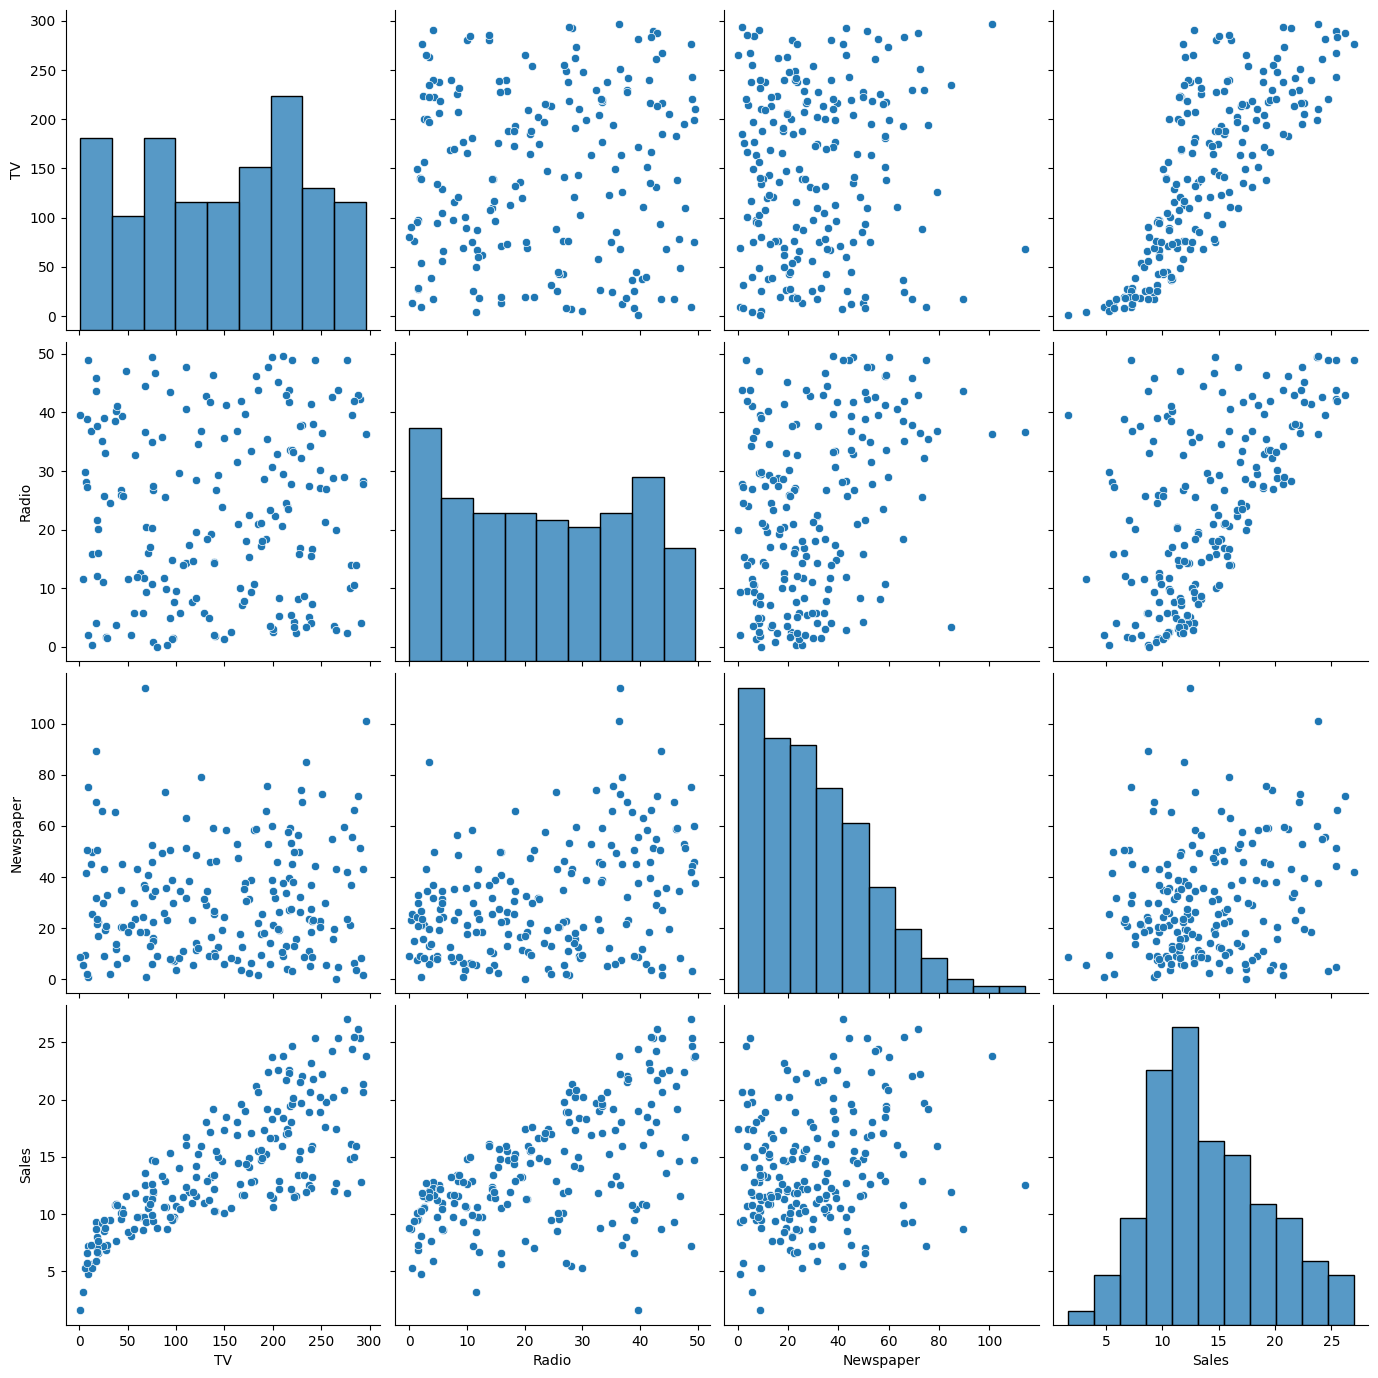

In [3]:
sns.pairplot(df, height=3.5)
print(df.describe().transpose())
plt.show()

---

## 4. Denoising

Denoising techniques were discussed in detail during the **Simple Linear Regression** section. While there are indeed **many advanced methods** available for handling noise in data, exploring them further is **beyond the scope** of this part of the project.

For now, the focus remains on building and interpreting the **Multiple Linear Regression model**, rather than on advanced data cleaning techniques.

           count        mean        std  min     25%     50%      75%    max
TV         198.0  146.688384  85.443221  0.7  74.800  149.75  218.475  293.6
Radio      198.0   23.130808  14.862111  0.0   9.925   22.40   36.325   49.6
Newspaper  198.0   29.777273  20.446303  0.3  12.650   25.60   44.050   89.4
Sales      198.0   13.980808   5.196097  1.6  10.325   12.90   17.375   27.0


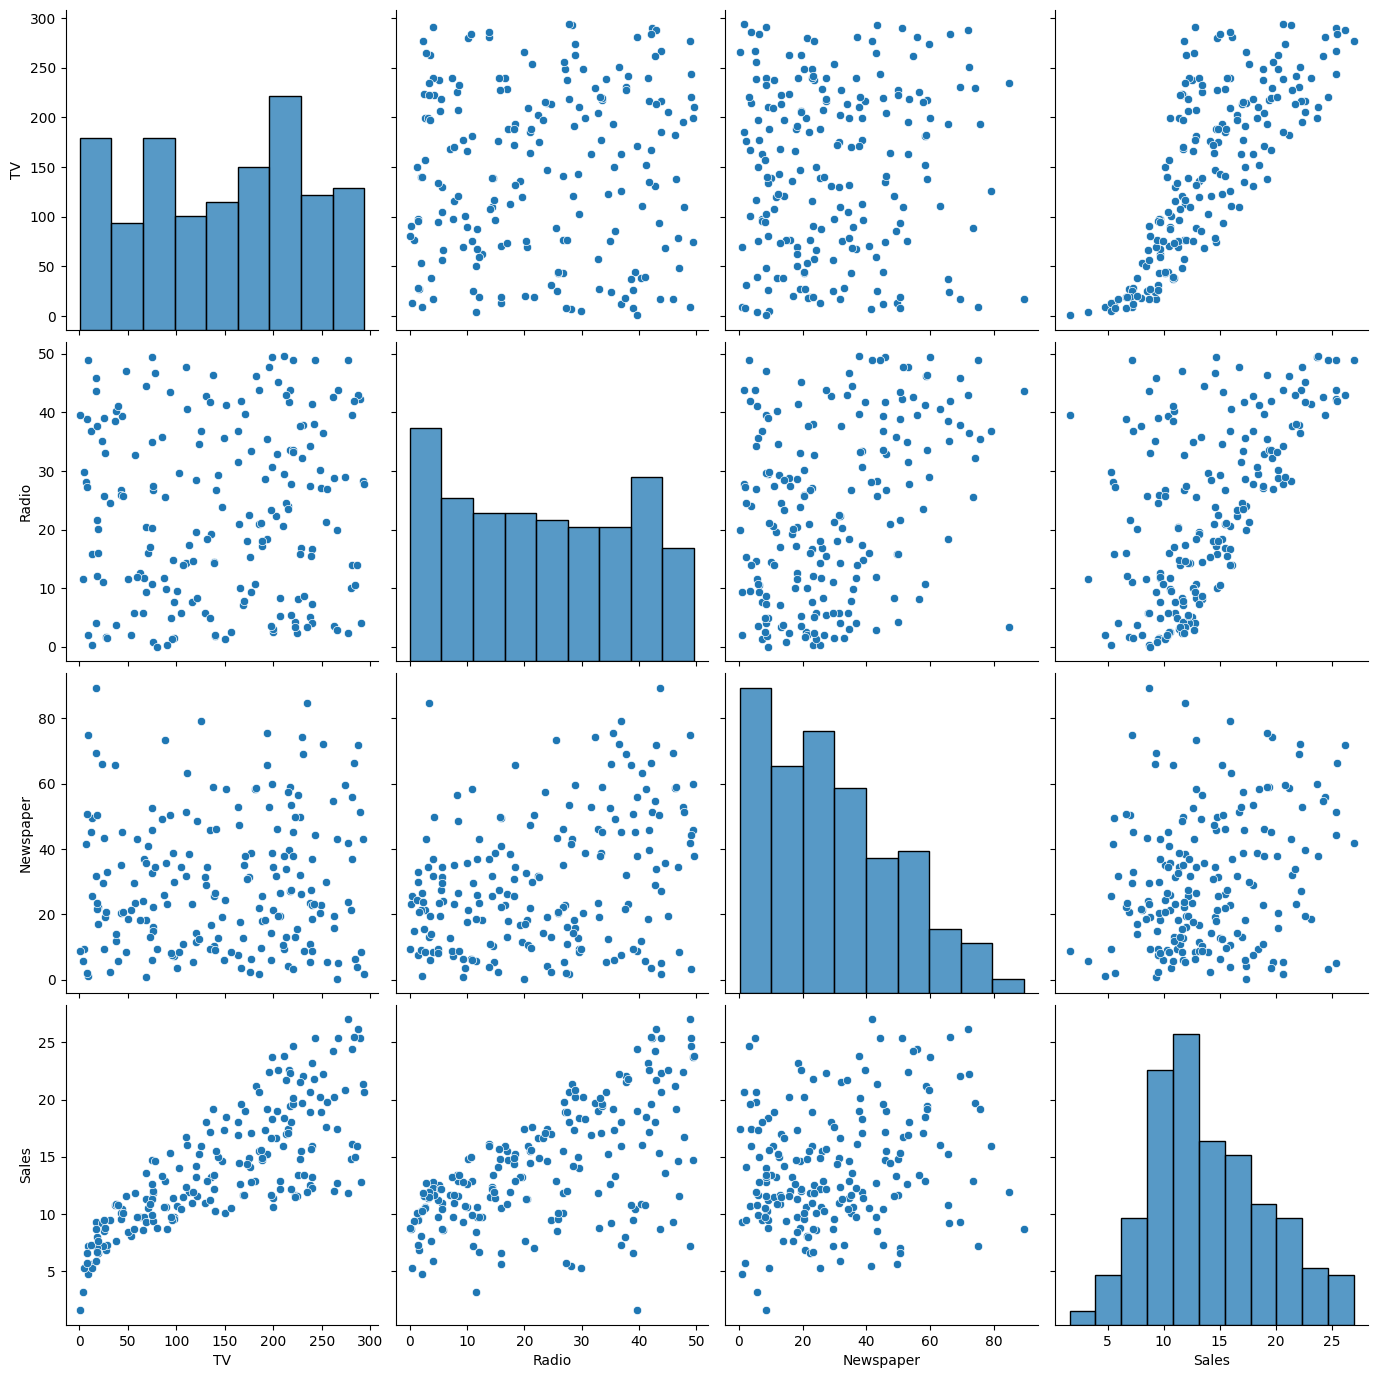

In [4]:
def iqr_denoise(df, columns, k=1.5):
    """Remove rows with outliers using IQR rule for specified columns."""
    mask = pd.Series(True, index=df.index)

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        mask &= (df[col] >= lower) & (df[col] <= upper)

    return df[mask]

# Apply to the dataset
df = iqr_denoise(df, ['TV', 'Radio', 'Newspaper', 'Sales'])

sns.pairplot(df, height=3.5)
print(df.describe().transpose())
plt.show()

---

## 5. Training the Model — Estimating the Regression Coefficients

For the Multiple Linear Regression (MLR) model, we use the least squares method to estimate the regression coefficients — the same foundational approach as in simple linear regression. However, unlike simple regression, the estimation in MLR is carried out using matrix algebra.

The [complete derivation](../theory-docs/04-OLS-MLR.ipynb) can be found in the following notebook: `theory-docs/04-OLS-MLR.ipynb`

The final matrix formula for estimating the regression coefficients is:

$$
\boxed{
\hat\beta = (X^\top X)^{-1} X^\top y
}
$$

where:

- X is the matrix of input features (with a column of ones for the intercept),

- y is the response vector,

- $\hat\beta$ is the vector of estimated coefficients.

---

### 5.1 Manual Calculation

In [5]:
# Step 1: Extract features and target
features = ['TV', 'Radio', 'Newspaper']
X = df[features].values
y = df['Sales'].values.reshape(-1, 1)

# Step 2: Add intercept term
n_samples = X.shape[0]
X_b = np.concatenate([np.ones((n_samples, 1)), X], axis=1)

# Step 3: Normal Equation
XtX = np.dot(X_b.T, X_b)
XtX_inv = np.linalg.inv(XtX)
Xty = np.dot(X_b.T, y)
beta_hat = np.dot(XtX_inv, Xty)

# Step 4: Format as DataFrame
coef_names = ['Intercept'] + features
coef_df = pd.DataFrame(beta_hat, index=coef_names, columns=['Coefficient'])
print("Manual Computation — Coefficients:")
display(coef_df.round(4))

Manual Computation — Coefficients:


,Coefficient
Intercept,2.9523
TV,0.0457
Radio,0.1886
Newspaper,-0.0012


---

### 5.2 Calculate with Scikit-Learn

In [6]:
# Step 1: Extract features and target
features = ['TV', 'Radio', 'Newspaper']
X = df[features].values
y = df['Sales'].values.reshape(-1, 1)

# Step 2: Fit model
model = LinearRegression()
model.fit(X, y)

# Step 3: Store and format results as DataFrame
beta_sklearn = np.concatenate([[model.intercept_[0]], model.coef_.flatten()])
coef_names = ['Intercept'] + features
coef_df = pd.DataFrame(beta_sklearn, index=coef_names, columns=['Coefficient'])

print("Scikit-Learn Estimation — Coefficients:")
display(coef_df.round(4))

Scikit-Learn Estimation — Coefficients:


,Coefficient
Intercept,2.9523
TV,0.0457
Radio,0.1886
Newspaper,-0.0012


---

## 6. Separate Simple Linear Model v.s. Multiple Linear Model

In our previous Simple Linear Regression case study, we examined the relationship between a single predictor (TV spending) and the response (sales). Extending this by fitting separate simple regressions for each advertising medium (TV, Radio, Newspaper) introduces two major drawbacks:

1. **Lack of a unified prediction**  
   It is unclear how to make a single prediction of sales given the three advertising media budgets, since each of the budgets is associated with a separate regression equation. Each medium yields its own regression equation, making it unclear how to combine them into a single sales forecast when budgets for all three channels are available.

2. **Omitted-variable bias**  
   Estimating each coefficient in isolation ignores the influence of the other two media, potentially producing misleading estimates of each medium’s true effect on sales.

---

### 6.1 Separate Simple Linear Regression Summary

| Feature    | Intercept |  Slope  | SE(Slope) |  t-stat  | p-value |
|------------|-----------|---------|-----------|----------|---------|
| **TV**     |    7.0326 |  0.0474 |    0.0027 |  17.4001 |  0.0000 |
| **Radio**  |    9.3116 |  0.2016 |    0.0204 |   9.8840 |  0.0000 |
| **Newspaper** | 12.3193 |  0.0558 |    0.0177 |   3.1506 |  0.0019 |

- All three media budgets show a statistically significant positive slope when modeled alone.  

- Radio has the largest univariate effect on sales (slope ≈ 0.20), followed by Newspaper (≈ 0.055) and TV (≈ 0.047).  

- However, these individually-fitted slopes ignore potential overlaps between ad channels.

In [7]:
# List of features to model separately
features = ['TV', 'Radio', 'Newspaper']
results = []

for feature in features:
    X = df[[feature]].values
    y = df['Sales'].values.reshape(-1, 1)
    n = len(y)

    model = LinearRegression()
    model.fit(X, y)

    intercept = model.intercept_[0]
    slope = model.coef_[0][0]
    y_pred = model.predict(X)

    # Residuals and RSS
    residuals = y - y_pred
    RSS = np.sum(residuals ** 2)

    # Standard error of slope
    x_diff_sq_sum = np.sum((X - np.mean(X)) ** 2)
    RSE = np.sqrt(RSS / (n - 2))  # residual standard error
    SE_slope = RSE / np.sqrt(x_diff_sq_sum)

    # t-statistic and p-value
    t_stat = slope / SE_slope
    p_val = 2 * (1 - t.cdf(np.abs(t_stat), df=n - 2))

    results.append({
        'Feature': feature,
        'Intercept': intercept,
        'Slope': slope,
        'SE(Slope)': SE_slope,
        't-stat': t_stat,
        'p-value': p_val
    })

# Format and display
simple_lm_df = pd.DataFrame(results)
print("Simple Linear Regression Summary:")
display(simple_lm_df.round(4))

Simple Linear Regression Summary:


,Feature,Intercept,Slope,SE(Slope),t-stat,p-value
0,TV,7.0306,0.0474,0.0027,17.4001,0.0000
1,Radio,9.3166,0.2016,0.0204,9.8840,0.0000
2,Newspaper,12.3193,0.0558,0.0177,3.1506,0.0019


---

### 6.2 Multiple Linear Regression Summary

| Coefficient |  Value   |
|-------------|----------|
| **Intercept**   |  2.9523 |
| **TV**          |  0.0457 |
| **Radio**       |  0.1886 |
| **Newspaper**   | –0.0012 |


- Controlling for the other two media, **TV** remains a strong positive predictor (≈ 0.046 additional sales per unit spend).  

- **Radio** also retains a positive effect (≈ 0.189), slightly reduced from its univariate slope.  

- **Newspaper** turns slightly negative (≈ –0.001) and is effectively negligible—suggesting no unique contribution once TV and Radio are accounted for.  

- The drop (and sign-flip) in Newspaper’s coefficient highlights the omitted-variable bias present in the separate simple regressions.  

---

### 6.3 Correlation Matrix: Why we don't prefer Separate Linear Model

Does it make sense for the multiple regression to suggest no relationship between **sales** and **newpaper** while the simple linear regression implies the opposite? In fact it does. The reason will be discussed in the this section - Correlation matrix

- The correlation between **Radio** and **Newspaper** is **≈0.35**, indicating that markets with high newspaper spending also tend to allocate more to radio.  

- In a Simple Linear Regression (SLR), newspaper spend appears positively associated with sales. However, in a Multiple Linear Regression (MLR) that controls for all three media, newspaper is no longer significant.  

- Instead, **Radio** remains a strong predictor of sales. Because radio and newspaper budgets are correlated, newspaper spending acts as a **surrogate** for radio in the SLR model—“taking credit” for radio’s true effect on sales.  

- This counterintuitive pattern is common in real-world data. For example, a simple regression of shark attacks on ice-cream sales at a beach would show a positive relationship—yet banning ice cream wouldn’t reduce attacks. In reality, warmer temperatures drive both more ice-cream purchases and more beach visits (hence more shark sightings). A multi-variable regression including temperature reveals that ice-cream sales lose significance once weather is accounted for.  

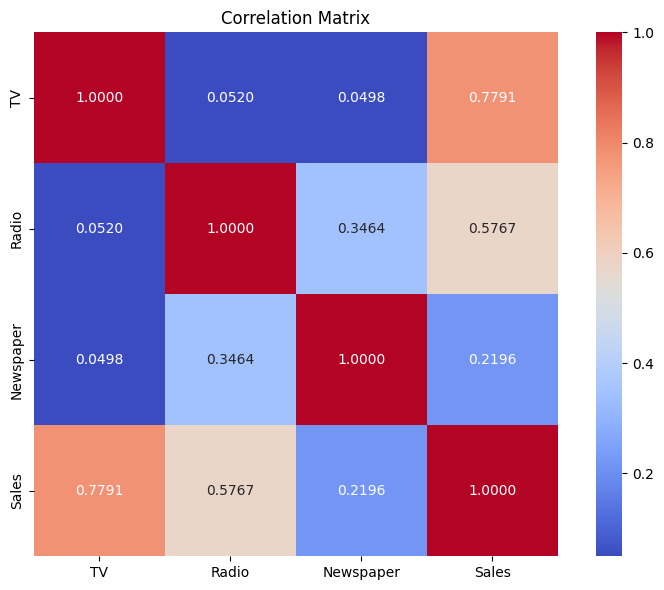

In [8]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

---

## 7. Hypothesis Testing: Is There a Relationship Between the Response and Predictors?

### 7.1 Test Statistic (F-statistic) for the Overall Model:

Goal: Test whether all predictors jointly have explanatory power on the response variable. (We normally do this step before evaluate individual coefficient)

$$
H_0: \beta_1 = \beta_2 = \dots = \beta_p = 0 \quad \text{(no predictor is useful)} \\
H_a: \text{At least one } \beta_j \ne 0
$$

Note:

[1] $\beta_0$(Intercept) is not 0

$$
F = \frac{(TSS - RSS) / p}{RSS / (n - p - 1)}
  = \frac{ \text{Explained variance} / p }{ \text{Unexplained variance} / (n - p - 1) } = \frac{MSR}{MSE}

$$

Where:
- $TSS = \sum_{i=1}^n (y_i - \bar{y})^2$
- $RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2$
- **MSR**: Mean Square Regression (explained variance)  
- **MSE**: Mean Square Error (unexplained variance)
- **p**: number of predictors
- **n**: number of observations
- $n - p - 1$: residual degrees of freedom

When there is **no relationship** between the response and predictors, F-statistic is expected **close to 1**. One the other hand, **if $H_a$ is true**, we expect F to be **greater than 1**. 

**Note:** F-statistic only tell you if at least one variable has relationship with response, but we don't know which variable(s).

> How to define F is large or not? it depends on case to case 
> 
> When n is large, F-statistic that is ust a lttle larger than 1 might still provide evidence against $H_0$ 
> 
> In contrast, a larger F-statistic is needed to reject $H_0$ if n is small 

---

### 7.2 Why don't we use t-test or p-values to perform hypothesis testing?

If we use the individual t-statistics and associated p-values in order to decide whether or not there is any association between the variables and the response, there is a very hight change that we will incorrectly conclude that there is a relationship(p-value < 0.5). However, the F-statistic does not suffer from this problem because it adjusts for the number of predictors.

When you do multiple individual t-tests (one for each predictor), you’re doing multiple hypothesis tests. This creates a risk of false positives — that is, you might incorrectly find a significant result just by chance.

Imagine this:
- Suppose none of the predictors actually affect the response.
- But you’re testing 10 predictors.
- Even if each one has only a 5% chance (p < 0.05) of appearing significant by accident, testing 10 of them means your chance of finding at least one false positive is much higher than 5% — closer to 40%!
  - That’s $1 − 0.05 = 0.95$ (i.e., 95% chance of correctly not rejecting the null when it’s true).
  - Assume all 10 tests are independent. What’s the chance of no false positives in all 10 tests? $0.95^{10} \approx 0.5987$
  - Now, what’s the chance of at least one false positive? That’s 1 minus the chance of no false positives: $1 - 0.95^{10} \approx 1 - 0.5987 = 0.4013$

The F-test does not test predictors one by one. Instead, it asks a global question:

“Do any of the predictors, as a group, help explain the response?”

It compares:
- A model with all the predictors (full model)
- Versus a model with none of the predictors (intercept-only model)

Because it considers all predictors together, it adjusts for the number of predictors and helps control the overall error rate — reducing the chance of false positives due to multiple tests.

---

### 7.3 Interpretation

The F-statistic is 553.5(code below). Since this is far larger than 1, it provides compelling evidence against the null hypothesis $H_0$. In other words, **the large F-statistic suggests that at least one of the advertising media must be related to sales**. 

In [9]:
# set X（predictors）and y（response）
X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

# add constant term for intercept
X = sm.add_constant(X)

# fit multiple linear regression model
model = sm.OLS(y, X).fit()

# Display full summary (includes std err, t, P>|t|, R², etc.)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     553.5
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           8.35e-95
Time:                        14:07:36   Log-Likelihood:                -383.24
No. Observations:                 198   AIC:                             774.5
Df Residuals:                     194   BIC:                             787.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9523      0.318      9.280      0.0

---

## 8. Deciding on Important Variables

**You can see from the previous table, Newspaper’s p-value is 0.860, why not just remove it directly? Why do I need forward, backward, or mixed selection?”**

| Predictor    | Coefficient | t-value | p-value | Interpretation |
|--------------|-------------|---------|---------|----------------|
| **const**     | 2.9523      | 9.280   | < 0.001 | Intercept is significant; baseline Sales when all media spend = 0. |
| **TV**        | 0.0457      | 32.293  | < 0.001 | **Highly significant** positive effect on Sales. |
| **Radio**     | 0.1886      | 21.772  | < 0.001 | **Highly significant** positive effect on Sales. |
| **Newspaper** | -0.0012     | -0.187  | 0.852   | ❌ Not significant; no evidence Newspaper affects Sales.(We will have detail discuss in the this section - Deciding on Important Variables) |

**We use forward/backward/mixed selection because: The p-values can change depending on which variables are in the model. You cannot trust the p-values in one fixed model to tell the whole story.**

- After F-statistic, if we conclude at least one of the predictors is related to the response, it is natural to wonder which ones

- It is possible that all of the predictor are associated with the response, but it is more often the case that the response is only associated with a subset of the predictors.(As we have examined in the previous section)

- The task of determining which predictors are associated with the response, in order to fit a single model involving only those predictors, is referred to as **variable selection**.

- Testing all combination($2^p$ or $2^{\text{number of coefficients}}$) of models doesn't work because you have too many models to test. Therefore, there are three classical approaches for this task:
  
  - **Forward selection**: Forward selection is a stepwise modeling approach that starts with no predictors and adds one variable at a time—the one that leads to the greatest reduction in RSS—until no further meaningful improvement is made or a stopping criterion is met.
  
  - **backward selection**: Backward selection is a stepwise modeling approach that starts with all candidate predictors and removes one variable at a time—the one that contributes the least to the model (e.g., highest p-value or smallest impact on RSS)—until no further meaningful improvement can be achieved or a stopping criterion is met.
  
  - **mixed selection**: Mixed selection is a modeling method that starts with no variables, and at each step, it adds the variable with the smallest p-value (if it’s below a threshold like 0.05), and also removes any variable already in the model if its p-value becomes too large or above the threshold(Because p-values can change when you add other variables to the model), repeating this process until no more variables can be added or removed.

> Backword selection cannot be used if p > n, which forward selection can always be used. Forward selection is a greedt approach, and might include variables early that later become redundant. Mixed selection can remedy this.

- The quality of model can be determined by:
  
  - Mallow's C
  
  - Akaike Information Criterion(AIC)
  
  - Bayesian information Criterion(BIC)
  
  - Adjusted R2

---

### 8.1 forward selection

In [10]:
custom_order = ['Newspaper', 'Radio', 'TV']  # You control this

selected, model = forward_selection(df, response='Sales', candidate_order=custom_order)

print("\nFinal variable selection order:", selected)
print(model.summary())


Step 1 | Current model: []
   → Evaluating 'Newspaper': p-value = 0.0019 | RSS = 5062.4941
   → Evaluating 'Radio': p-value = 0.0000 | RSS = 3549.6237
   → Evaluating 'TV': p-value = 0.0000 | RSS = 2090.1667
Added: TV (p = 0.0000 < 0.05)

Step 2 | Current model: ['TV']
   → Evaluating 'Newspaper': p-value = 0.0000 | RSS = 1915.9127
   → Evaluating 'Radio': p-value = 0.0000 | RSS = 556.5000
Added: Radio (p = 0.0000 < 0.05)

Step 3 | Current model: ['TV', 'Radio']
   → Evaluating 'Newspaper': p-value = 0.8518 | RSS = 556.3996
No variable meets the significance threshold. Stopping.

Final variable selection order: ['TV', 'Radio']
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     834.4
Date:                Mon, 21 Jul 2025   Prob (F-

---

### 8.2 backward selection

In [11]:
selected, model = backward_selection(df, response='Sales')

print("\nFinal variables after backward selection:", selected)
print(model.summary())


Step 1 | Current model: ['TV', 'Radio', 'Newspaper']
P-values and RSS:
   - TV: p-value = 0.0000
   - Radio: p-value = 0.0000
   - Newspaper: p-value = 0.8518
   RSS = 556.3996
Removing 'Newspaper' (p = 0.8518 > 0.05)

Step 2 | Current model: ['TV', 'Radio']
P-values and RSS:
   - TV: p-value = 0.0000
   - Radio: p-value = 0.0000
   RSS = 556.5000
All variables have p-values below threshold. Stopping.

Final variables after backward selection: ['TV', 'Radio']
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     834.4
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           2.60e-96
Time:                        14:07:36   Log-Likelihood:                -383.26
No. Observations:                 198   AIC:                 

---

### 8.3 plot model(Sales V.S. TV & Radio)

So, at this point, we can confidently say we should only use TV and Radio as predictors in the model, and Newspaper should be ignored.

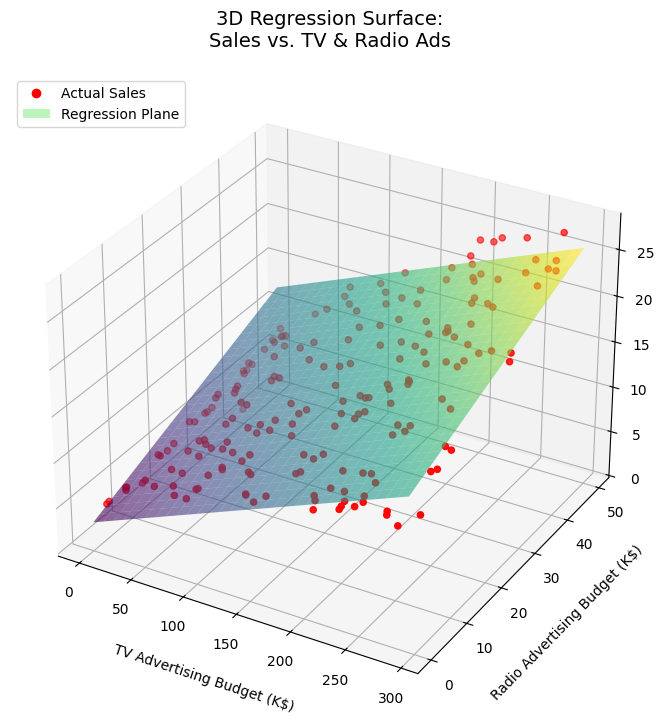

In [12]:
# Prepare input
X = df[['TV', 'Radio']]
y = df['Sales']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
b0, b1, b2 = model.params

# Meshgrid for the plane
tv_range    = np.linspace(X['TV'].min(),    X['TV'].max(),    30)
radio_range = np.linspace(X['Radio'].min(), X['Radio'].max(), 30)
TV, Radio   = np.meshgrid(tv_range, radio_range)
Sales_plane = b0 + b1*TV + b2*Radio

# Plot
fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111, projection='3d')

# Data points
ax.scatter(X['TV'], X['Radio'], y, c='red', marker='o', label='Actual Sales')

# Regression plane
ax.plot_surface(TV, Radio, Sales_plane, alpha=0.6, cmap='viridis')

# Labels & Title
ax.set_xlabel('TV Advertising Budget (K$)',    labelpad=12)
ax.set_ylabel('Radio Advertising Budget (K$)', labelpad=12)
ax.set_zlabel('Predicted Sales (Units)',      labelpad=10)  # smaller pad
ax.set_title('3D Regression Surface:\nSales vs. TV & Radio Ads',
             pad=20,
             fontsize=14)

# Legend
scatter_proxy = plt.Line2D([0], [0], linestyle="none", marker='o', color='red', label='Actual Sales')
plane_proxy   = plt.Rectangle((0,0),1,1,fc='lightgreen', alpha=0.6, label='Regression Plane')
ax.legend(handles=[scatter_proxy, plane_proxy], loc='upper left')

# Expand margins so Z-label isn't clipped
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

plt.show()

---

## 9. Model Fit

- **RSE** and **$R^2$** are most common numerical measures of model fit

### 9.1 R² Evaluation

In [13]:
# Model 1: With Newspaper
X_with_news = df[['TV', 'Radio', 'Newspaper']]
X_with_news = sm.add_constant(X_with_news)
model_with_news = sm.OLS(y, X_with_news).fit()

# Model 2: Without Newspaper
X_without_news = df[['TV', 'Radio']]
X_without_news = sm.add_constant(X_without_news)
model_without_news = sm.OLS(y, X_without_news).fit()

# Print R² values
print(f"R² with Newspaper:    {model_with_news.rsquared:.5f}")
print(f"R² without Newspaper: {model_without_news.rsquared:.5f}")

R² with Newspaper:    0.89539
R² without Newspaper: 0.89537


- From the above printed log, we can tell the R² with Newspaper is 0.89539, and R² without Newspaper is 0.89537.
- In other words, there is a small increase in R² if we include advertising in the model that already contains TV and radio advertising, even though we saw earlier that the p-value for newpaper advertising is not significant from previous part. **It turns out that R² will always increase when more variables are added to the model, even if those variables are only weakly associated with the response. This is due to the fact that adding another variable always results in a decrease in the residual sum of squares on the training data.**
- The fact that adding newspaper advertising to the model containing only TV and radio advertising leads to just a tiny increase in R² provides additional evidence that newspaper can be dropped from the model.

In [14]:
# Model 1: With Newspaper
X_with_news = df[['TV']]
X_with_news = sm.add_constant(X_with_news)
model_with_news = sm.OLS(y, X_with_news).fit()

# Model 2: Without Newspaper
X_without_news = df[['TV', 'Radio']]
X_without_news = sm.add_constant(X_without_news)
model_without_news = sm.OLS(y, X_without_news).fit()

# Print R² values
print(f"R² with model only contains TV:    {model_with_news.rsquared:.5f}")
print(f"R² with model contains TV and Radio: {model_without_news.rsquared:.5f}")

R² with model only contains TV:    0.60703
R² with model contains TV and Radio: 0.89537


- By contrast, if model **only contain TV**, we will have **R² of 0.60703**. 
- **Adding radio** to the model leads to a substantial improvement in **R2, 0.89537**. This implies that a model that uses TV and radio expenditures to predict sales is substantially better than one that uses only TV advertising.

---

### 9.2 RSE Evaluation

$$\text{RSE} = \sqrt{\frac{1}{n - p - 1} \cdot \text{RSS}}$$

In [15]:
y = df['Sales']

def compute_rse(model):
    rss = np.sum(model.resid ** 2)
    n = model.nobs
    p = model.df_model  # excludes intercept
    rse = np.sqrt(rss / (n - p - 1))
    return rse

# Model 1: TV only
X1 = sm.add_constant(df[['TV']])
model1 = sm.OLS(y, X1).fit()
rse1 = compute_rse(model1)

# Model 2: TV + Radio
X2 = sm.add_constant(df[['TV', 'Radio']])
model2 = sm.OLS(y, X2).fit()
rse2 = compute_rse(model2)

# Model 3: TV + Radio + Newspaper
X3 = sm.add_constant(df[['TV', 'Radio', 'Newspaper']])
model3 = sm.OLS(y, X3).fit()
rse3 = compute_rse(model3)

# Print results
print(f"RSE (TV only):                     {rse1:.4f}")
print(f"RSE (TV + Radio):                  {rse2:.4f}")
print(f"RSE (TV + Radio + Newspaper):      {rse3:.4f}")

RSE (TV only):                     3.2656
RSE (TV + Radio):                  1.6893
RSE (TV + Radio + Newspaper):      1.6935


The RSE result align with previous R² result. The model uses TV and radio expenditures to predict sales is much more accurate(on the training data) than one that only uses TV spending. There is no point also using newspaper spending as a predictor in the model. 

---

## 10. Prediction

### 10.1 What Is Confidence Interval (CI) and Prediction Interval (PI)?

#### Confidence Interval (CI)

**CI tells us: "Where is the average?"**

Imagine you spend **$100k on TV** and **$20k on Radio** in **100 cities**.

A **confidence interval** answers: "What range will the **average sales** across those 100 cities fall into?"

So it's about the **average** result, not one specific case.

---

#### Prediction Interval (PI)

**PI tells us: "Where might a new case fall?"**

Now imagine just **one new city** spends **$100k on TV** and **$20k on Radio**.

A **prediction interval** answers:
👉 "What range might this **one city’s sales** fall into?"

So it's about a **single new outcome**, and includes more uncertainty.

It includes **two sources of uncertainty**:
1. **Model uncertainty** (from estimating the regression coefficients — same as in confidence interval)
2. **Irreducible error** (random noise in individual outcomes)

---

#### Prediction Interval vs Confidence Interval

| Question Type                    | CI (Confidence Interval)        | PI (Prediction Interval)        |
|----------------------------------|----------------------------------|----------------------------------|
| Meaning                          | Range for the **average** result | Range for **a new single** result |
| Uncertainty included             | Only model estimate              | Model estimate **+ randomness**  |
| Width                            | Narrower                         | **Wider**                        |
| Used when...                     | Predicting **average** behavior  | Predicting **individual** cases  |

**Prediction Intervals are always wider than Confidence Intervals**, because they account for both model uncertainty and randomness in new data.

---

### 10.2 How to Calculate

Let:

- `ŷ` be the predicted value at some input `x₀`
- `s²` be the estimated residual variance
- `SE(ŷ)` be the standard error of the prediction

#### **Confidence Interval (CI)**:
$$
\hat{y} \pm t^* \cdot \text{SE}(\hat{y})
$$

#### **Prediction Interval (PI)**:
$$
\hat{y} \pm t^* \cdot \sqrt{ \text{SE}(\hat{y})^2 + s^2 }
$$

Where $ t^* $ is the critical t-value for the desired confidence level (e.g., 95%).

---


In [16]:
def compute_ci_pi(tv_spend, radio_spend, df, alpha=0.05):
    """
    Compute and print 95% Confidence Interval (CI) and Prediction Interval (PI)
    for a new observation given TV and Radio spend.

    Parameters:
    -----------
    tv_spend : float
        TV advertising spend (in thousands of dollars)
    radio_spend : float
        Radio advertising spend (in thousands of dollars)
    df : pandas DataFrame
        DataFrame containing 'TV', 'Radio', and 'Sales' columns
    alpha : float (default=0.05)
        Significance level for 100*(1-alpha)% interval (e.g. 0.05 for 95%)

    Returns:
    --------
    ci : tuple
        (lower, upper) bound of confidence interval
    pi : tuple
        (lower, upper) bound of prediction interval
    """
    # Fit model using TV and Radio as predictors
    X = df[['TV', 'Radio']]
    y = df['Sales']
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()

    # New input for prediction
    new_data = pd.DataFrame({'const': [1], 'TV': [tv_spend], 'Radio': [radio_spend]})
    prediction = model.get_prediction(new_data)
    summary = prediction.summary_frame(alpha=alpha)

    # Extract CI and PI bounds
    ci_lower, ci_upper = summary[['mean_ci_lower', 'mean_ci_upper']].values[0]
    pi_lower, pi_upper = summary[['obs_ci_lower', 'obs_ci_upper']].values[0]

    # Print formatted results
    print(f"95% Confidence Interval (for mean sales): [{ci_lower:.3f}, {ci_upper:.3f}] (in 1000s units)")
    print(f"95% Prediction Interval (for one city's sales): [{pi_lower:.3f}, {pi_upper:.3f}] (in 1000s units)")

    return (ci_lower, ci_upper), (pi_lower, pi_upper)

In [17]:
_ = compute_ci_pi(tv_spend=100, radio_spend=20, df=df)

95% Confidence Interval (for mean sales): [10.986, 11.533] (in 1000s units)
95% Prediction Interval (for one city's sales): [7.917, 14.602] (in 1000s units)


### 10.3 Result Interpretation

Given that $100,000 is spent on TV advertising and #20,000 is spent on radio advertising in each city, 
- the 95% CI is [10986, 11533], and we interpret this as 95% of intervals of this form will contain the true value of average sales.
- The 95% PI is [7917, 14602], and we interpret this as 95% of intervals of this form will contain the true value of Y(sales) for this city.

---

## 11. Synergy/Interaction Effect

- In previous analysis, we assumed that the effect of sales of increasing one advertising medium is independent of the amount spent one the other media. 
- The Linear model states that the average inscrease in sales associated with one-unit inscrease in TV is always Beta1, regardless of the amount spent on radio. However, this simple model may be incorrect.Given a fixed budget of $100,000, spending half on radio and half on TV may increase sales more than allocating the entire amount to either TV or to radio. So, we need to test the **Synergy/Interaction effect**.
- the current linear model seems to overestimate sales for instances in which most of the advertising money was spent exclusively on either TV or radio. It underestimates sales for instances where the budget was split between the two media. This pronounced non-linear pattern suggests as a synergy or interaction effect between the advertising media, whereby combining the media together results in a bigger boost to sales than using any single medium.

Without Interaction:

$$\text{Sales} = \beta_0 + \beta_1 \cdot \text{TV} + \beta_2 \cdot \text{Radio} + \varepsilon$$

With Interaction Term:

$$\text{Sales} = \beta_0 + \beta_1 \cdot \text{TV} + \beta_2 \cdot \text{Radio} + \beta_3 \cdot (\text{TV} \times \text{Radio}) + \varepsilon$$

In [18]:
df['TV_Radio'] = df['TV'] * df['Radio']

X1 = sm.add_constant(df[['TV', 'Radio']])
model1 = sm.OLS(y, X1).fit()

# RSE = sqrt(RSS / df)
rss1 = np.sum(model1.resid ** 2)
rse1 = np.sqrt(rss1 / model1.df_resid)

# --- Model 2: With interaction term ---
X2 = sm.add_constant(df[['TV', 'Radio', 'TV_Radio']])
model2 = sm.OLS(y, X2).fit()

rss2 = np.sum(model2.resid ** 2)
rse2 = np.sqrt(rss2 / model2.df_resid)

# --- Print results ---
print("Model WITHOUT Interaction Term:")
print(f"R²  = {model1.rsquared:.4f}")
print(f"RSE = {rse1:.4f}")

print("\nModel WITH Interaction Term:")
print(f"R²  = {model2.rsquared:.4f}")
print(f"RSE = {rse2:.4f}")

Model WITHOUT Interaction Term:
R²  = 0.8954
RSE = 1.6893

Model WITH Interaction Term:
R²  = 0.9676
RSE = 0.9418


The R² for the model(with interaction term) is 96.76%, compared to only 89.54% for the model that predicts sales using TV and radio without an interaction term. This means that (96.76-89.54)/(100-89.54) = 69% of variability in sales that remians after fitting the additive model has been explained by the interaction term.

In [19]:
X = sm.add_constant(df[['TV', 'Radio', 'TV_Radio']])
y = df['Sales']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1934.
Date:                Mon, 21 Jul 2025   Prob (F-statistic):          3.19e-144
Time:                        14:07:36   Log-Likelihood:                -267.07
No. Observations:                 198   AIC:                             542.1
Df Residuals:                     194   BIC:                             555.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7577      0.247     27.304      0.0

From the model printed out p-value, we can also learn that the interaction term has extremely low p-value, indicating that there is strong evidence for alternative hypothesis. In other words, **it is clear that the true relationship is not additive**. 

> Note: “It is clear that the true relationship is not additive — does that mean it’s not linear?”
> 
> Answer: Not necessarily.
> 
> It suggests that the additive linear model is too simple and doesn’t fit the data well.
> 
> But we can still use a linear model with interaction or polynomial terms to capture this more complex relationship.

Example of Linear model: $Sales = β0 + β1·TV + β2·Radio + β3·TV·Radio$

Example of Non-Linear model: $Sales = β0 + β1·TV + β2·Radio + β3·TV·Radio + β4·TV² + β5·Radio² + ...$

---

### 11.1 Interaction term between important feature only

We typically:
1. First identify main effects (individual variables with low p-values),
2. Then test interactions between them.

Why?

Because if a variable isn’t important by itself, it’s usually (not always) unlikely to contribute a useful interaction — it just adds noise.

Interaction only makes sense when the individual variables already have some effect — otherwise you’re mixing noise with noise.

---

### 11.2 What if we have multiple interaction term.

This part is discussed above. We can use methods like:
- Forward selection: Start with main effects → add interactions that improve the model (using RSS, R², or AIC).
- Backward selection: Start with all main effects + interactions → remove unhelpful ones.
- Mixed selection: A combination.

You can apply these using p-values, AIC, BIC, or cross-validation MSE.

---

## 12. Non-linearity of the Data

Up to this point, we have been working with linear regression models by default. A linear model assumes a straight-line relationship between the input features and the response variable. In many real-world applications, this is a reasonable starting point. But:

> How do we know when a linear model is no longer sufficient?  
> Could a non-linear model provide a better fit to the data?

---

### 12.1 A Simulated Example: Predicting Sales Based on Marketing Budget

Let’s imagine a fictional marketing scenario:

A company wants to predict sales based on how much they spend on TV advertising. To simulate this, we generated data with a quadratic relationship:

$$\text{Sales} = 3 + 2 \cdot \text{TV} - 0.5 \cdot \text{TV}^2 + \varepsilon$$

where $\varepsilon$ is random noise to simulate real-world variation.

---

Step 1: Fit a Linear Model

We first try fitting a linear model:

$$\text{Sales} = \beta_0 + \beta_1 \cdot \text{TV}$$

We then plotted the residuals (actual − predicted values) vs. the fitted values. This is a key diagnostic tool in regression analysis.

---

Step 2: Fit a Quadratic Model (Non-Linear)

We then fit a quadratic model:

$$\text{Sales} = \beta_0 + \beta_1 \cdot \text{TV} + \beta_2 \cdot \text{TV}^2$$

This adds a non-linear component to the model to capture curvature in the relationship.

---

Step 3: Compare **Residual Plots**

| Model              | Residual Plot Pattern                        | Conclusion                        |
|-------------------|----------------------------------------------|-----------------------------------|
| **Linear**         | Residuals show a clear curved (U-shaped) trend | Model misses systematic pattern   |
| **Quadratic**      | Residuals are randomly scattered around 0     | Model fits the data better        |

The red trend line in the residual plot helps reveal patterns:
- In the **linear model**, it curves significantly ⇒ **non-linearity present**
- In the **quadratic model**, the red line is almost flat ⇒ **good fit**

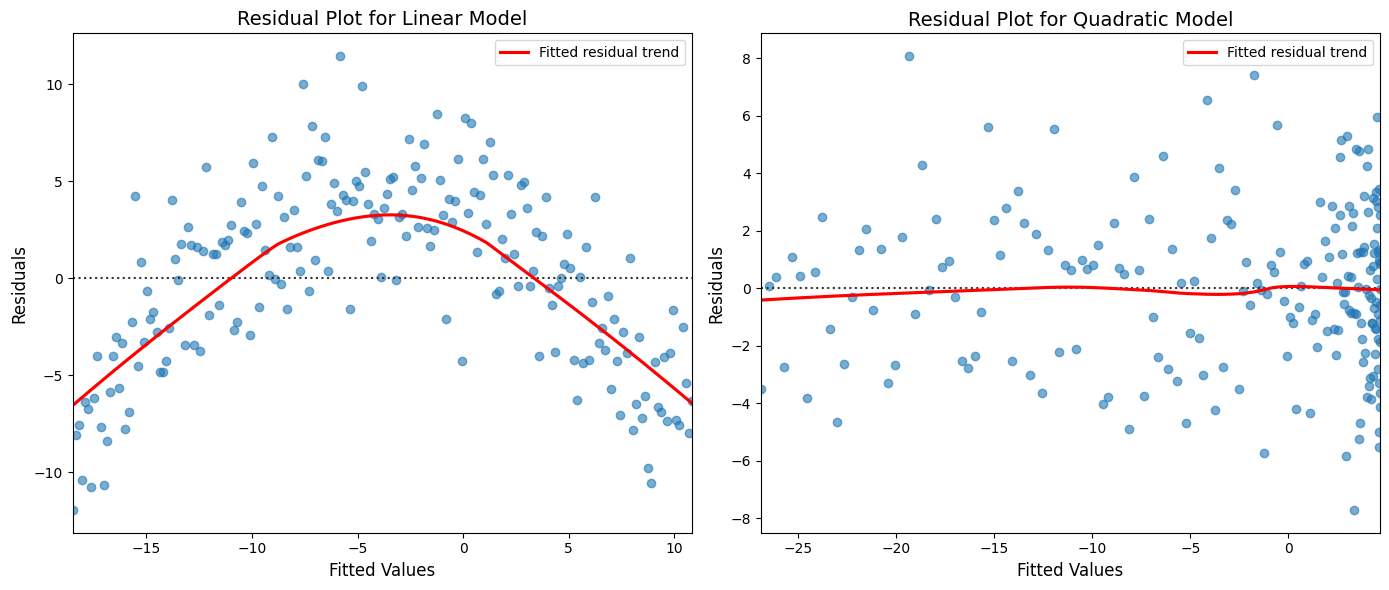

In [20]:
# Step 1: Simulate data
np.random.seed(42)
X = np.linspace(0, 10, 200)
y_true = 3 + 2 * X - 0.5 * X**2  # Quadratic relationship
noise = np.random.normal(0, 3, size=X.shape)
y = y_true + noise

# Step 2: Fit linear model
X_linear = X.reshape(-1, 1)
lin_model = LinearRegression().fit(X_linear, y)
y_pred_linear = lin_model.predict(X_linear)
residuals_linear = y - y_pred_linear

# Step 3: Fit quadratic model
poly = PolynomialFeatures(degree=2)
X_quad = poly.fit_transform(X_linear)
quad_model = LinearRegression().fit(X_quad, y)
y_pred_quad = quad_model.predict(X_quad)
residuals_quad = y - y_pred_quad

# Step 4: Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Linear Model Residual Plot ---
sns.residplot(x=y_pred_linear, y=residuals_linear, lowess=True, 
              ax=axes[0], scatter_kws={'alpha':0.6}, line_kws={'color': 'red', 'label': 'Fitted residual trend'})
axes[0].set_title("Residual Plot for Linear Model", fontsize=14)
axes[0].set_xlabel("Fitted Values", fontsize=12)
axes[0].set_ylabel("Residuals", fontsize=12)
axes[0].legend()

# --- Quadratic Model Residual Plot ---
sns.residplot(x=y_pred_quad, y=residuals_quad, lowess=True, 
              ax=axes[1], scatter_kws={'alpha':0.6}, line_kws={'color': 'red', 'label': 'Fitted residual trend'})
axes[1].set_title("Residual Plot for Quadratic Model", fontsize=14)
axes[1].set_xlabel("Fitted Values", fontsize=12)
axes[1].set_ylabel("Residuals", fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

**Residual plots** are useful graphical tool for identifying non-linearity. Ideally, the residual plot will show no discernible pattern. The presence of a pattern may indicate a problem with some aspect of the linear model.

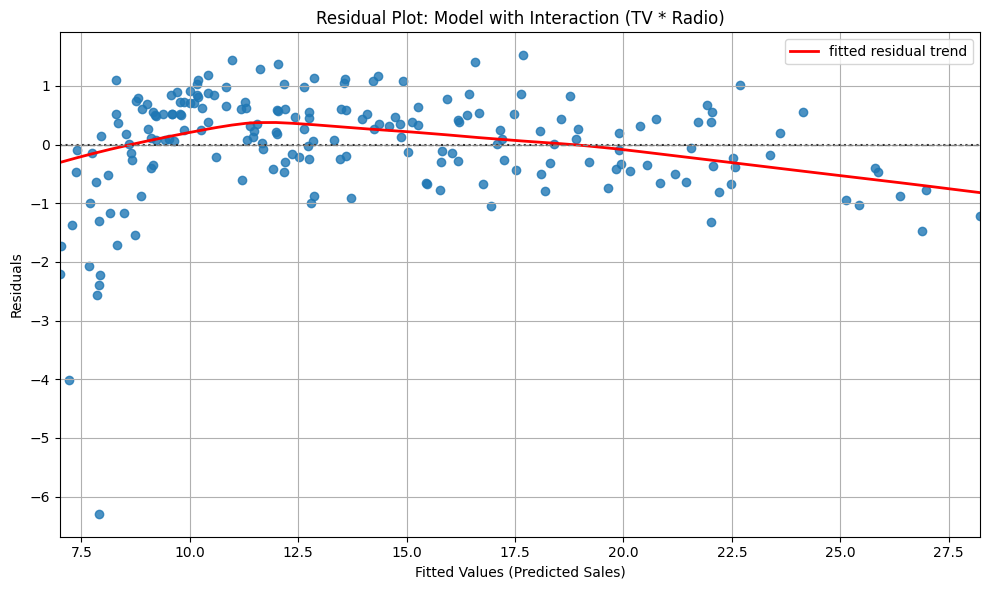

In [21]:
df['TV_Radio'] = df['TV'] * df['Radio']

# Define predictors and response
X = sm.add_constant(df[['TV', 'Radio', 'TV_Radio']])
y = df['Sales']

# Fit the model
model = sm.OLS(y, X).fit()

# Get fitted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid

# Plot residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2, 'label': 'fitted residual trend'},)
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.xlabel("Fitted Values (Predicted Sales)")
plt.ylabel("Residuals")
plt.title("Residual Plot: Model with Interaction (TV * Radio)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From this, we can observe signs of non-linear effects in the residual plot, indicating that a simple linear model may not fully capture the underlying relationship in the data. Therefore, we cannot confidently conclude that a linear model is the most appropriate choice for this dataset.

**Note:**  

[1] We will not explore polynomial regression in this case study, as our focus is to deepen the understanding and application of standard linear regression techniques.

## 13. Market Plan

### 1. Is there a relationship between sales and advertising budget?

Based on the results from **hypothesis testing**, we conclude that at least one advertising channel is significantly related to sales, as the **F-statistic is much greater than 1**. 

### 2. Which media are associated with sales?

In the section **"Deciding on Important Variables"**, we applied both **forward and backward selection**, which confirmed that **TV and Radio** spending have a strong impact on sales. In contrast, **Newspaper** spending shows a **high p-value (0.852)**, suggesting it does **not have a statistically significant relationship** with sales and can be excluded from the model.

### 3. How strong is the relationship?

The **Residual Standard Error (RSE)** is **1.69 units**, while the **mean value of sales** is **13.98**, resulting in a **percentage error of approximately 12%**. This suggests the model’s predictions are reasonably close to the actual values. Additionally, the **R² statistic** indicates that the predictors explain **about 89.5% of the variability in sales**, demonstrating a **strong relationship** between advertising spending (TV and Radio) and sales.

### 4. How large is the association between each medium and sales?

To assess the magnitude of association between each advertising medium and sales, we examine the **regression coefficients** from the linear regression model. These coefficients represent the **estimated change in sales** for a **one-unit increase** in spending on each advertising channel, **holding other variables constant**.

the confidence interval for:
- TV: (0.043, 0.048)
- Radio: (0.171, 0.206)
- Newspaper: (-0.014, 0.011)  

From the coefficient, we have:
- A **TV coefficient of 0.0457** implies that for every **$1,000 increase in TV advertising**, sales are expected to increase by **approximately 45.7 units**.
- A **Radio coefficient of 0.1886** indicates a **larger impact**: each additional $1,000 spent on radio is associated with an **increase of 188.6 units in sales**.
- A **Newspaper coefficient close to 0** (and a high p-value) suggests **little to no impact** on sales.

These values not only tell us **which media channels are effective**, but also **how effective** they are in driving sales, with **Radio** showing a stronger association than **TV**, and **Newspaper** showing **no significant effect**.

### 5. Is there synergy among the advertising media?

Yes, there is evidence of **synergy between TV and Radio advertising**. When an **interaction term** between TV and Radio spending is included in the model, it is associated with a **small p-value**, indicating the interaction is **statistically significant**.

Moreover, this inclusion leads to a **substantial improvement in model performance**, with the **R² increasing from approximately 90% to nearly 97%**. This suggests that **combined spending on TV and Radio has a greater impact on sales** than the sum of their individual effects, highlighting the presence of **synergistic effects** between these two media channels.

### 6. Is the relationship linear?

To determine whether the relationship between predictors and sales is linear, we examined the **residual plots**. In a truly linear relationship, the residuals should display a **random scatter** around the horizontal axis, with **no obvious pattern or curve**.

However, in our analysis, the residual plots reveal a **non-linear pattern**, suggesting that the assumption of linearity may not hold. This indicates that the relationship between advertising spending and sales is **not perfectly linear**, and incorporating **non-linear terms or transformations** might improve the model fit.